In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
img1_path = "image1.jpg"
img2_path = "image2.jpg"

In [3]:
img1 = cv2.imread(img1_path)
img2 = cv2.imread(img2_path)

In [4]:
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

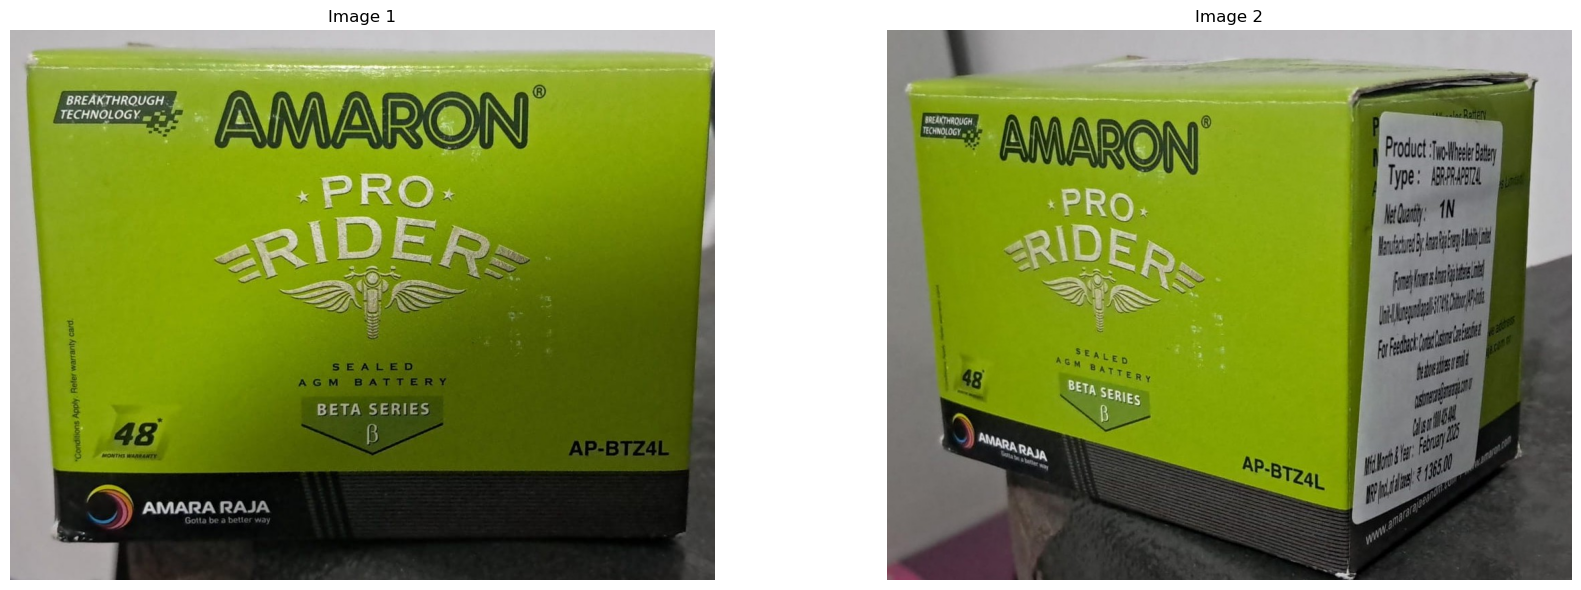

In [5]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.title('Image 1')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.title('Image 2')
plt.axis('off')

plt.tight_layout()
plt.show()

In [6]:
def sift_ransac(img1_path, img2_path, ransac_thresh = 5.0):
    
    img1_color = cv2.imread(img1_path)
    img2_color = cv2.imread(img2_path)

    img1 = cv2.cvtColor(img1_color, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2_color, cv2.COLOR_BGR2GRAY)

    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    print(f"Total Keypoints in Image 1: {len(kp1)}")
    print(f"Total Keypoints in Image 2: {len(kp2)}")

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    good_matches = []
    pts1 = []
    pts2 = []
    
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)
            pts1.append(kp1[m.queryIdx].pt)
            pts2.append(kp2[m.trainIdx].pt)

    pts1 = np.float32(pts1)
    pts2 = np.float32(pts2)

    print(f"Good Matches before RANSAC: {len(good_matches)}")

    # Apply RANSAC to remove outliers
    H, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC, ransac_thresh)
    matches_mask = mask.ravel().tolist()
    
    inlier_matches = [good_matches[i] for i in range(len(matches_mask)) if matches_mask[i]]

    print(f"Good Matches after RANSAC (Inliers): {len(inlier_matches)}")

    result = cv2.drawMatches(img1_color, kp1, img2_color, kp2, inlier_matches, None, 
                             matchColor = (0,255,0), singlePointColor = None,
                             flags = cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    plt.figure(figsize=(16, 8))
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.title("RANSAC Inlier Matches")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

Total Keypoints in Image 1: 2753
Total Keypoints in Image 2: 4144
Good Matches before RANSAC: 285
Good Matches after RANSAC (Inliers): 156


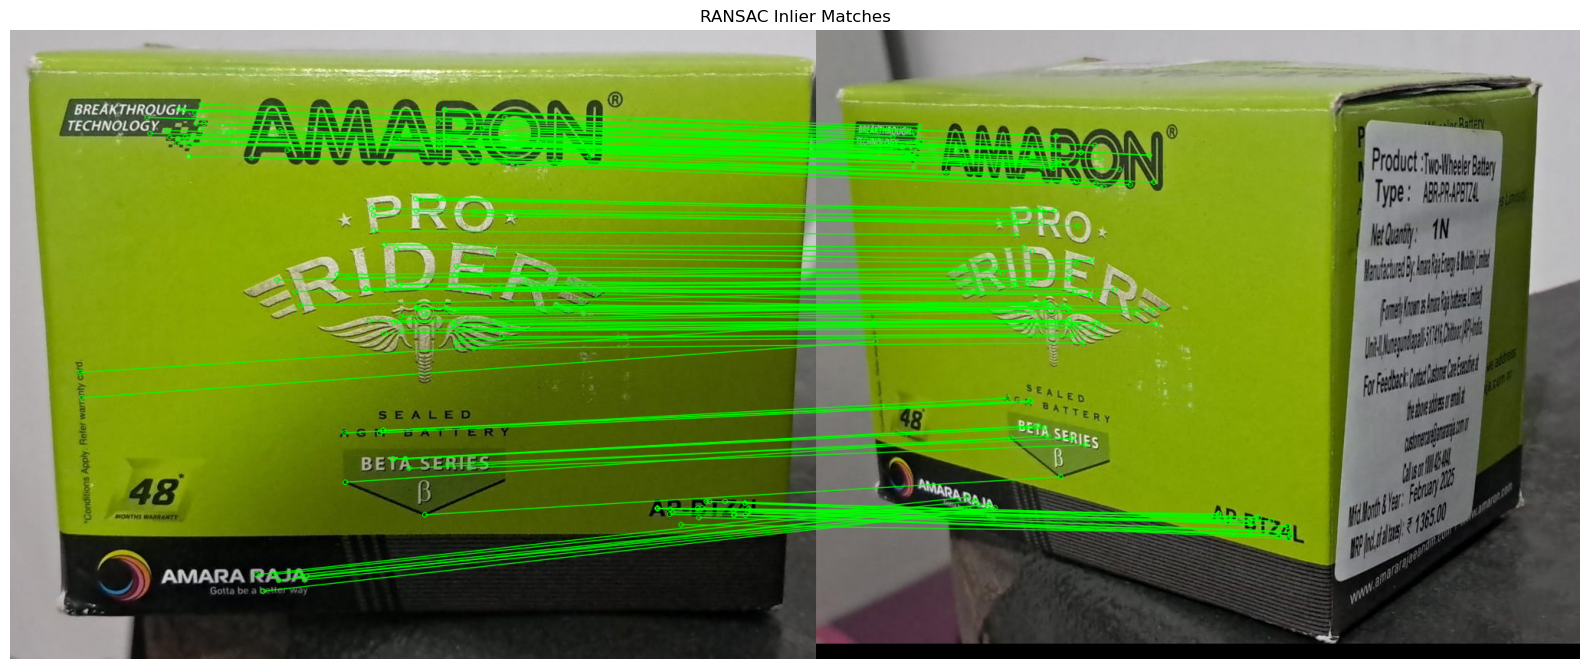

In [7]:
sift_ransac(img1_path, img2_path)

Total Keypoints in Image 1: 2753
Total Keypoints in Image 2: 4144
Good Matches before RANSAC: 285
Good Matches after RANSAC (Inliers): 123


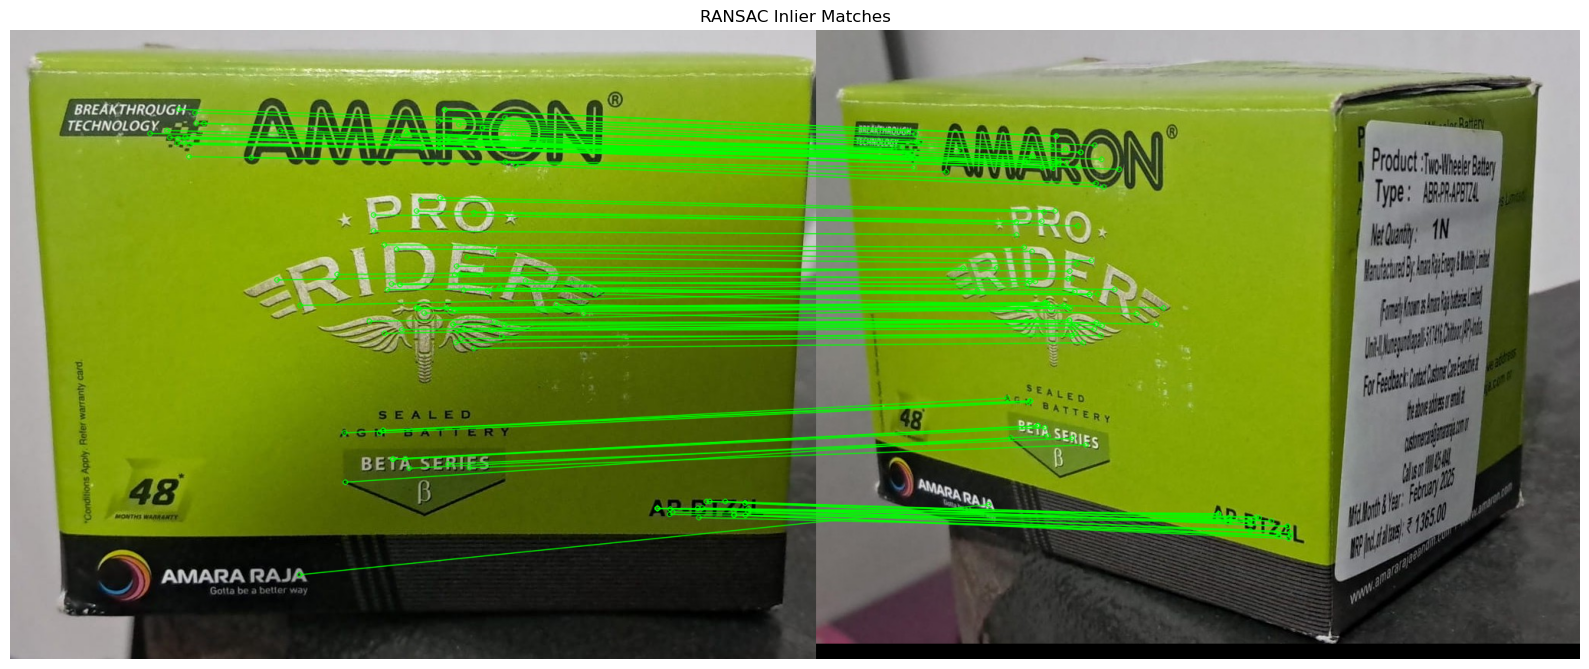

In [8]:
# Tight RANSAC threshold (only very precise inliers kept)
sift_ransac(img1_path, img2_path, ransac_thresh=2.0)

#### A lower RANSAC threshold of 2.0 made the inlier selection stricter, resulting in fewer matches. It removed more potential outliers but risked discarding some correct matches that were slightly misaligned.

Total Keypoints in Image 1: 2753
Total Keypoints in Image 2: 4144
Good Matches before RANSAC: 285
Good Matches after RANSAC (Inliers): 169


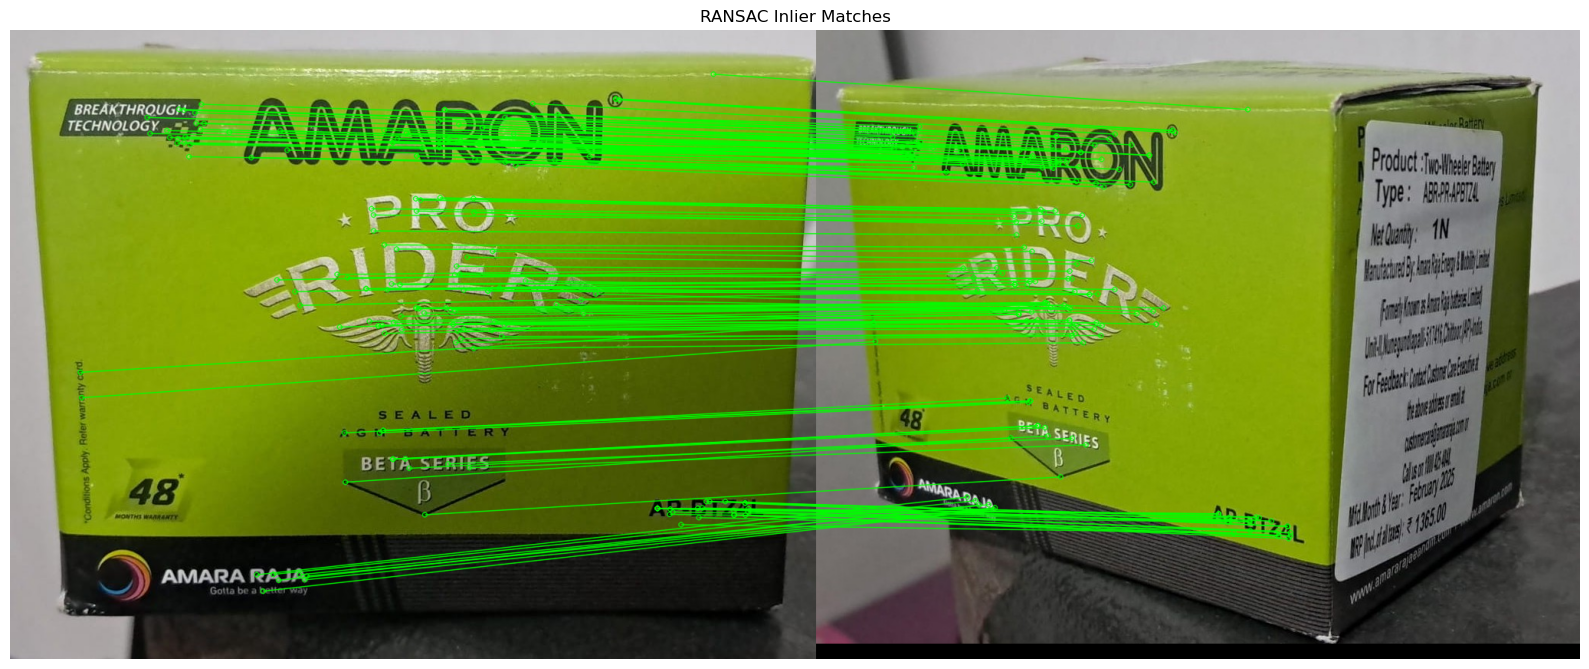

In [9]:
# Looser RANSAC threshold (more leniency, risk of outliers)
sift_ransac(img1_path, img2_path, ransac_thresh=10.0)

#### A higher RANSAC threshold of 10.0 accepted more matches, even those with larger geometric error. This retained more inliers but also slightly increased the risk of including false matches.

Total Keypoints in Image 1: 2753
Total Keypoints in Image 2: 4144
Good Matches before RANSAC: 285
Good Matches after RANSAC (Inliers): 156


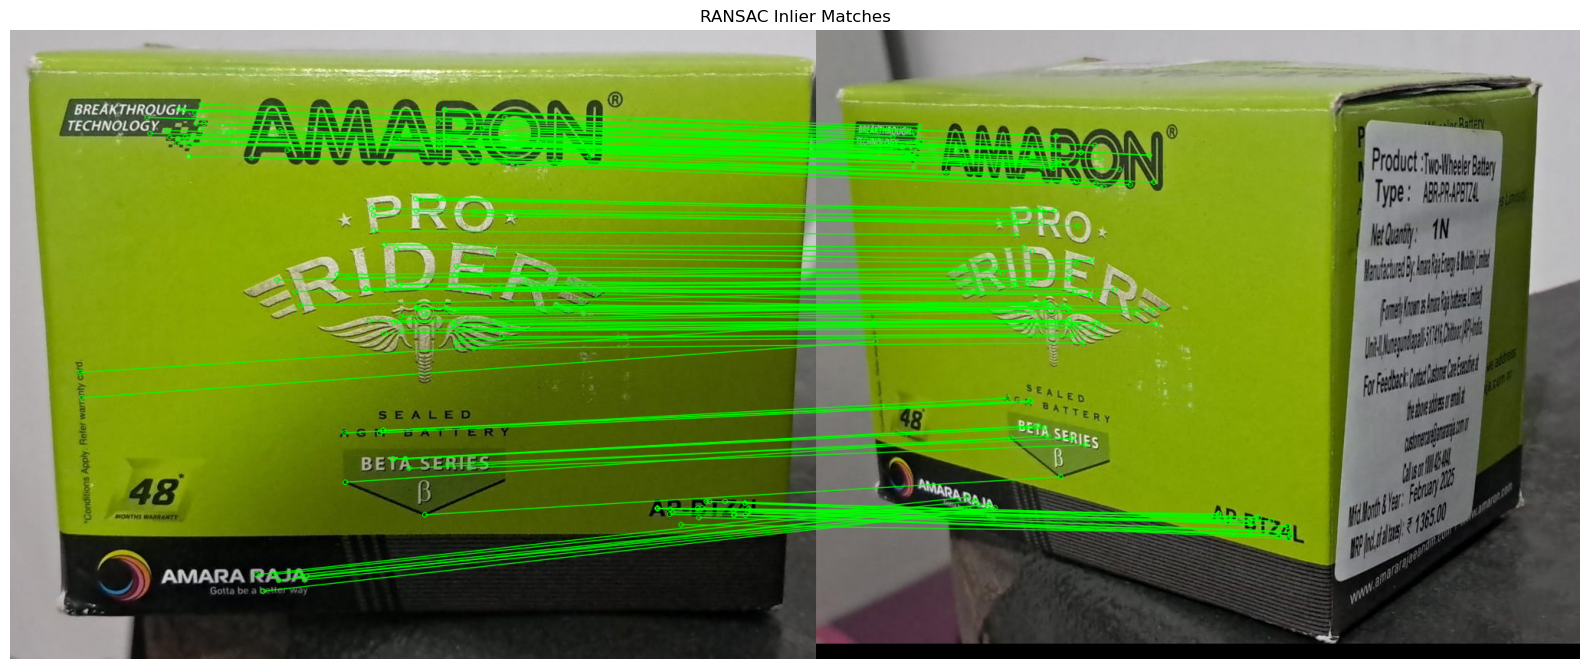

In [10]:
# Medium threshold (balanced)
sift_ransac(img1_path, img2_path, ransac_thresh=5.0)

#### A balanced threshold of 5.0 provided a good trade-off between match quantity and geometric accuracy. It preserved valid matches while eliminating clear outliers, resulting in stable transformation fitting.
